In [28]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [29]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [30]:
from core import SITE_NAMES, FREQ_GROUPS
import clustering as clstr
import bout.assembly as bt
import bout.clustering as clstr
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline

from cli import get_file_paths

In [47]:
def get_between_bout_intervals_in_secs(bout_metrics):
    
    intervals = bout_metrics['start_time_of_bout'] - bout_metrics['end_time_of_bout'].shift(1)
    bout_metrics.insert(0, 'between_bout_intervals', intervals)
    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bm_LF_df = bout_metrics.set_index('ref_time')
    first_calls_per_day = bm_LF_df.resample('D').first()['start_time_of_bout']
    first_valid_calls_per_day = pd.DatetimeIndex(first_calls_per_day.loc[~first_calls_per_day.isna()].values)
    bm_LF_df.loc[first_valid_calls_per_day, 'between_bout_intervals'] = pd.NaT
    intervals = bm_LF_df['between_bout_intervals'].values
    valid_intervals = intervals[~np.isnan(intervals)]
    ipis_s = valid_intervals.astype('float32')/1e9

    return ipis_s

Looking at Foliage
Foliage HF Min: 26880.0
Foliage HF Max: 79680.0
Foliage HF Mean: 44564.0523703293
Foliage HF Median: 44160.0
Foliage HF Mode: 42240.0


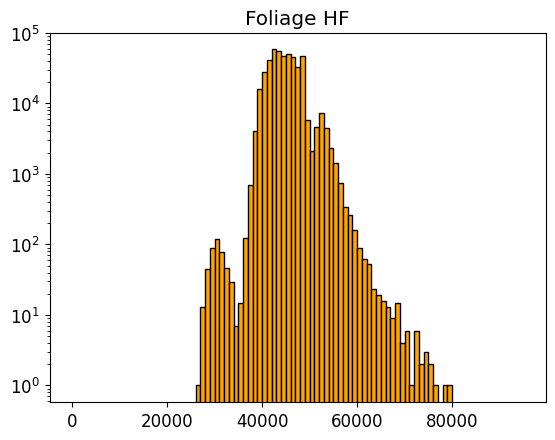

In [51]:
site_key = 'Foliage'
freq_key = 'HF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000
print(f'Looking at {fig_details["site_name"]}')
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')

stat_arr = location_df.peak_frequency.astype(float)
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")
print(f"{site_key} {freq_key} Mode: {stat_arr.mode().item()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 96000, 1000), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

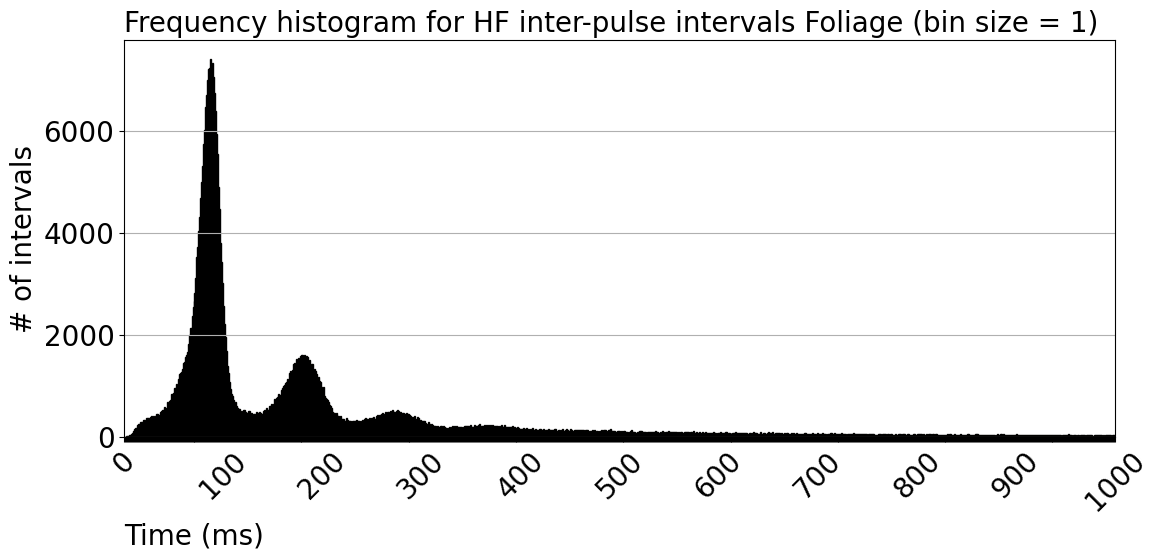

In [52]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 1
fig_details['time_end'] = 1000

ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [53]:
hist_f[1][np.argmax(hist_f[0])]

87.0

In [54]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000

location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_85890/1571415492.py:9: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)


Fagen&Young method has 1549459205 missassigned points
Slater method has 3106815 missassigned points
Sibly method has 2593617 missassigned points
Optim BCI has less misassignments than BCI? True
513197 more points assigned correctly


In [55]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.0010392364783138482, intercept=12.013521627314312, rvalue=-0.8895497530416783, pvalue=1.244427028492477e-69, stderr=3.783381294765082e-05, intercept_stderr=0.0437412984971598),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.0010392364783138482,
  'num_intervals_slater': 158741971.0245453},
 {'metrics': LinregressResult(slope=-3.0404862167473686e-07, intercept=6.1550935983060455, rvalue=-0.9511525325468777, pvalue=0.0, stderr=7.518009670645527e-11, intercept_stderr=0.0007518310187177396),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 3.0404862167473686e-07,
  'num_intervals_slater': 1549459204.8727875})

In [56]:
nlin_results

{'solution': array([3.19913365e+08, 1.43015561e-03, 1.54945920e+09, 3.04048622e-07]),
 'fast_num_intervals': 319913364.59681493,
 'fast_lambda': 0.0014301556126642757,
 'slow_num_intervals': 1549459204.1340506,
 'slow_lambda': 3.040486216171114e-07,
 'bci': 4810.635828375243}

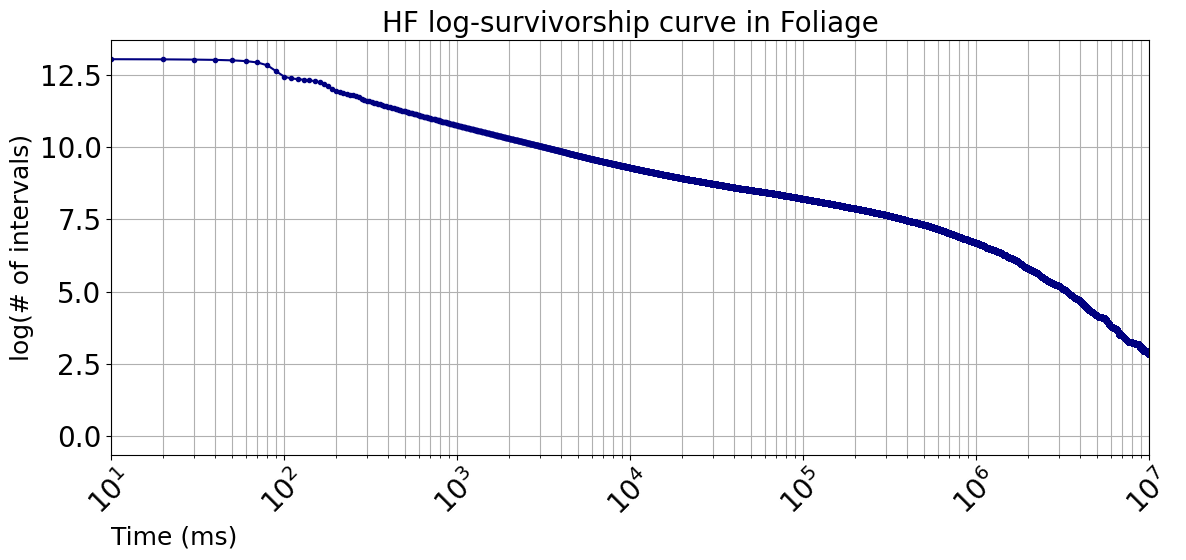

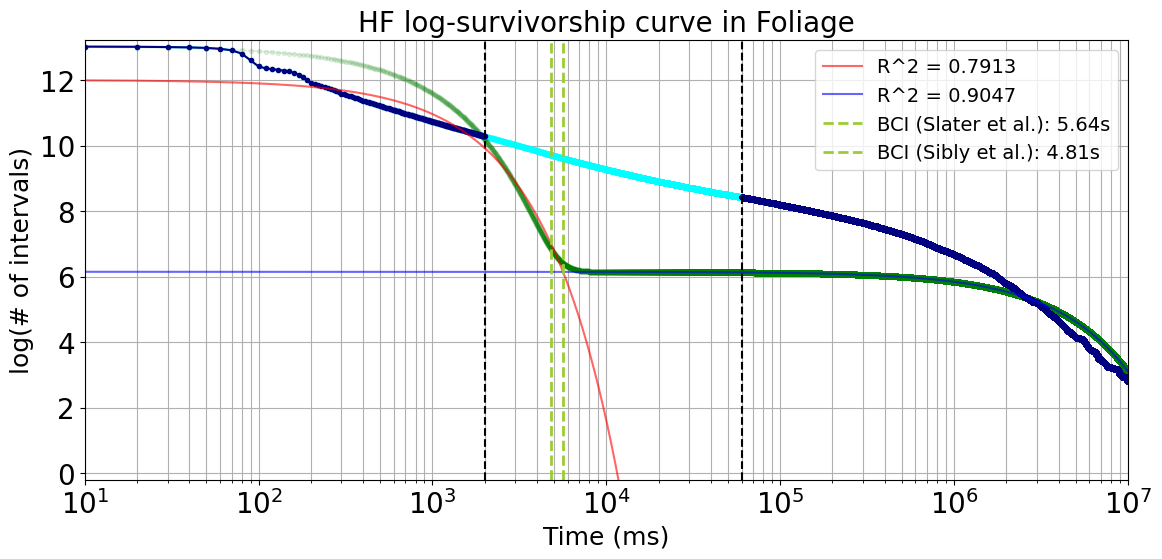

In [57]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [58]:
data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['detector_tag'] = 'bd2'
data_params['assembly_type'] = 'kmeans'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['index_time_block_in_secs'] = 5
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')
bout_params = bt.get_bout_params_from_location(location_df, data_params)
bout_params

{'site_key': 'Foliage', 'HF_bci': 5638.8922528331}

In [59]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
tagged_dets = bt.classify_bouts_in_detector_preds_for_freqgroups(dc_applied_df, bout_params)
bout_metrics = bt.construct_bout_metrics_from_classified_dets(tagged_dets)
bout_metrics

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,2022-06-15 04:32:25.191500000,2022-06-15 04:32:38.647600,145.1915,158.6476,145.1915,158.6476,35781.0,66901.0,HF,2022-06-15 04:30:00,2022-06-15 04:30:00,15,0 days 00:00:13.456100,13.4561
1,2022-06-15 04:32:47.924500000,2022-06-15 04:32:48.296300,167.9245,168.2963,167.9245,168.2963,40937.0,61634.0,HF,2022-06-15 04:30:00,2022-06-15 04:30:00,3,0 days 00:00:00.371800,0.3718
2,2022-06-15 04:33:02.671500000,2022-06-15 04:33:11.133600,182.6715,191.1336,182.6715,191.1336,37500.0,64434.0,HF,2022-06-15 04:30:00,2022-06-15 04:30:00,13,0 days 00:00:08.462100,8.4621
3,2022-06-15 04:34:17.526499999,2022-06-15 04:34:43.243100,257.5265,283.2431,257.5265,283.2431,39218.0,88982.0,HF,2022-06-15 04:30:00,2022-06-15 04:30:00,33,0 days 00:00:25.716600001,25.7166
4,2022-06-15 04:35:04.040500000,2022-06-15 04:35:13.982100,304.0405,313.9821,304.0405,313.9821,40078.0,65149.0,HF,2022-06-15 04:30:00,2022-06-15 04:30:00,14,0 days 00:00:09.941600,9.9416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12735,2022-10-17 08:07:24.554500000,2022-10-17 08:07:34.165300,444.5545,454.1653,444.5545,454.1653,43515.0,66154.0,HF,2022-10-17 08:00:00,2022-10-17 08:00:00,34,0 days 00:00:09.610800,9.6108
12736,2022-10-17 08:07:45.604500000,2022-10-17 08:07:49.045100,465.6045,469.0451,465.6045,469.0451,44375.0,68054.0,HF,2022-10-17 08:00:00,2022-10-17 08:00:00,31,0 days 00:00:03.440600,3.4406
12737,2022-10-17 08:10:50.256500000,2022-10-17 08:10:57.468200,650.2565,657.4682,650.2565,657.4682,42656.0,60402.0,HF,2022-10-17 08:00:00,2022-10-17 08:00:00,34,0 days 00:00:07.211700,7.2117
12738,2022-10-17 08:11:20.943500000,2022-10-17 08:11:23.516700,680.9435,683.5167,680.9435,683.5167,42656.0,63219.0,HF,2022-10-17 08:00:00,2022-10-17 08:00:00,12,0 days 00:00:02.573200,2.5732


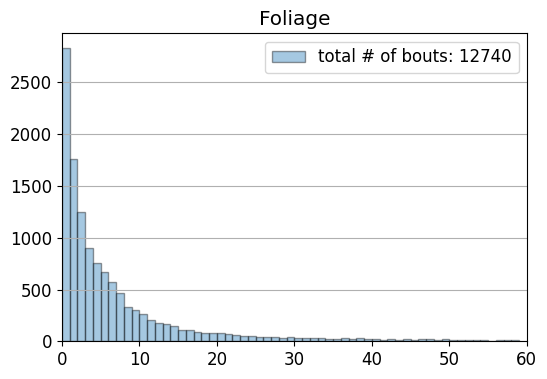

In [60]:
bout_metrics_HF = bout_metrics[bout_metrics['freq_group']=='HF'].copy()
hf_bci = bout_params['HF_bci']

bout_durations_raw_HF = bout_metrics_HF["bout_duration_in_secs"].astype(float)
hf_labels = f'total # of bouts: {len(bout_durations_raw_HF)}'

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size':12})
plt.title(f'{SITE_NAMES[site_key]}')
x_lims = [0, 60]
x_step = 1
plt.hist(bout_durations_raw_HF, bins=np.arange(x_lims[0],x_lims[-1], x_step), edgecolor='k', label=hf_labels, alpha=0.4)
plt.grid(axis='y')
plt.legend(loc=1)
plt.xlim(x_lims[0],x_lims[-1])
plt.show()

In [61]:
bout_durations_raw_HF

0        13.4561
1         0.3718
2         8.4621
3        25.7166
4         9.9416
          ...   
12735     9.6108
12736     3.4406
12737     7.2117
12738     2.5732
12739     2.4771
Name: bout_duration_in_secs, Length: 12740, dtype: float64

Foliage HF Min: 0.0502
Foliage HF Max: 1409.889199
Foliage HF Mean: 11.796223901491366
Foliage HF Median: 3.55165


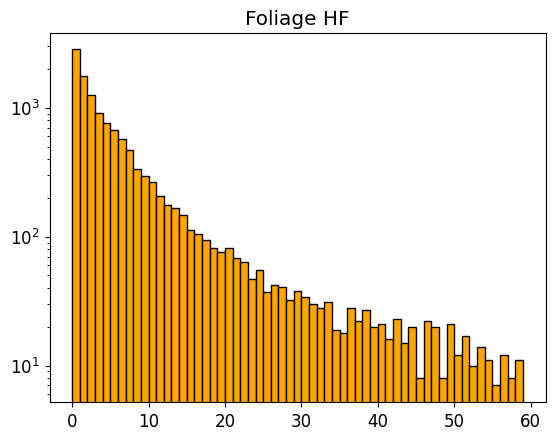

In [62]:
stat_arr = bout_durations_raw_HF
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 60, 1), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

In [63]:
bout_metrics['bout_duration_in_secs'].sort_values()

1855        0.050200
10037       0.053300
5756        0.065100
9487        0.065700
7954        0.066600
            ...     
1127      829.872700
4201      856.481100
1081      874.108400
4206     1016.390000
1071     1409.889199
Name: bout_duration_in_secs, Length: 12740, dtype: float64

In [64]:
bbis_s = get_between_bout_intervals_in_secs(bout_metrics)

Foliage HF Min: 5.638999938964844
Foliage HF Max: 30240.59765625
Foliage HF Mean: 243.49574279785156
Foliage HF Median: 21.382200241088867


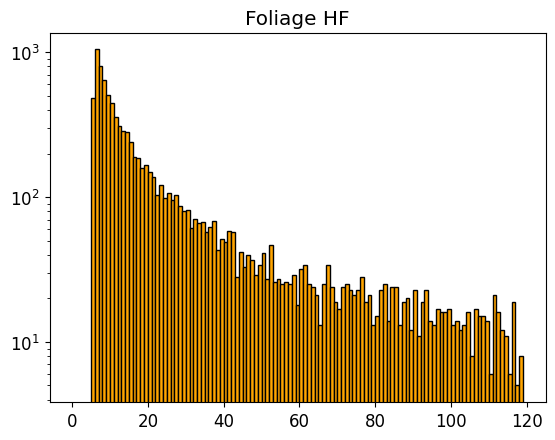

In [65]:
stat_arr = bbis_s
print(f"{site_key} {freq_key} Min: {np.min(stat_arr)}")
print(f"{site_key} {freq_key} Max: {np.max(stat_arr)}")
print(f"{site_key} {freq_key} Mean: {np.mean(stat_arr)}")
print(f"{site_key} {freq_key} Median: {np.median(stat_arr)}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 120, 1), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

Looking at Foliage
Foliage LF Min: 11520.0
Foliage LF Max: 38400.0
Foliage LF Mean: 26753.6229340007
Foliage LF Median: 26880.0
Foliage LF Mode: 25920.0


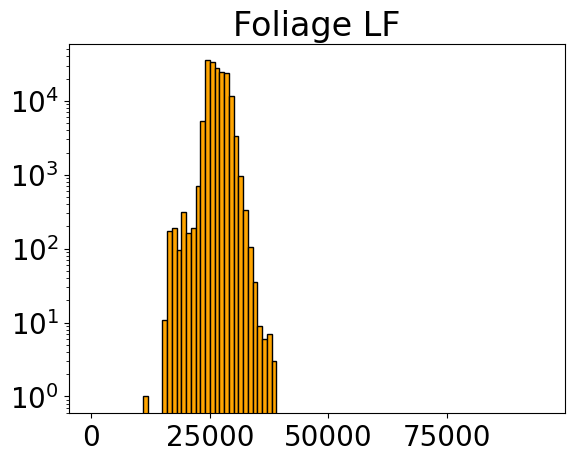

In [32]:
site_key = 'Foliage'
freq_key = 'LF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000
print(f'Looking at {fig_details["site_name"]}')
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')

stat_arr = location_df.peak_frequency.astype(float)
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")
print(f"{site_key} {freq_key} Mode: {stat_arr.mode().item()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 96000, 1000), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

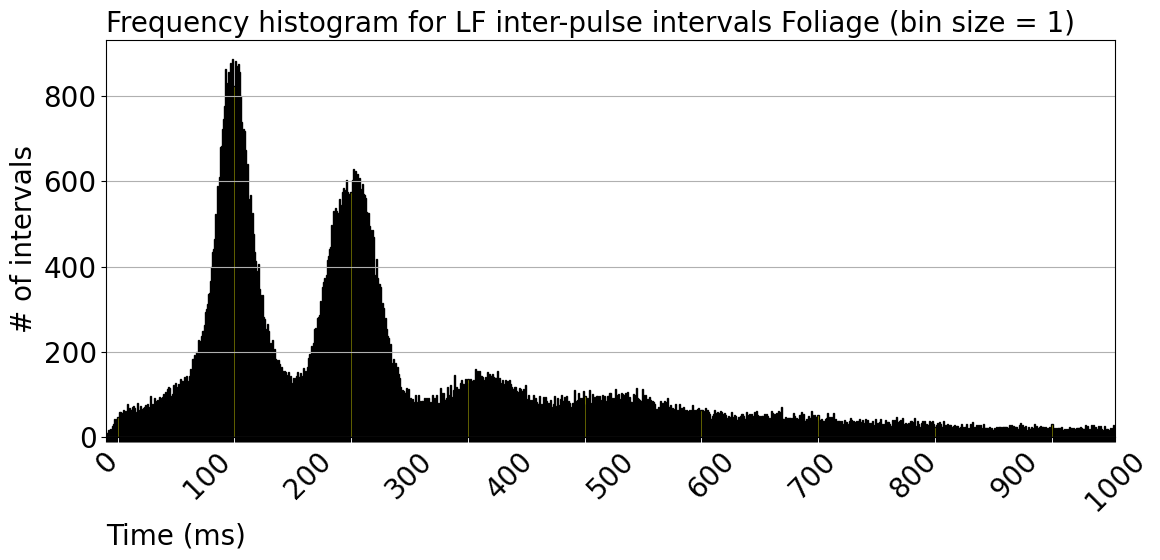

In [33]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 1
fig_details['time_end'] = 1000

ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [34]:
hist_f[1][np.argmax(hist_f[0])]

125.0

In [50]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000
print(f'Looking at {fig_details["site_name"]}')

Looking at Foliage


In [36]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_85890/1452210673.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)


Fagen&Young method has 2375248923 missassigned points
Slater method has 4052925 missassigned points
Sibly method has 4047632 missassigned points
Optim BCI has less misassignments than BCI? True
5293 more points assigned correctly


In [37]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.0007903492955632499, intercept=11.541259883579267, rvalue=-0.9073186684375195, pvalue=8.158118416222352e-77, stderr=2.596213762260656e-05, intercept_stderr=0.03001594401669444),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.0007903492955632499,
  'num_intervals_slater': 130162658.75896686},
 {'metrics': LinregressResult(slope=-2.138159303210278e-07, intercept=6.230217747881241, rvalue=-0.9521164958154869, pvalue=0.0, stderr=4.2218590625686864e-11, intercept_stderr=0.0006468501110755738),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 2.138159303210278e-07,
  'num_intervals_slater': 2375248922.997744})

In [38]:
nlin_results

{'solution': array([1.96966518e+08, 8.52860137e-04, 2.37524893e+09, 2.13815930e-07]),
 'fast_num_intervals': 196966518.3337973,
 'fast_lambda': 0.0008528601369127112,
 'slow_num_intervals': 2375248926.092418,
 'slow_lambda': 2.1381593042132218e-07,
 'bci': 6804.007045035358}

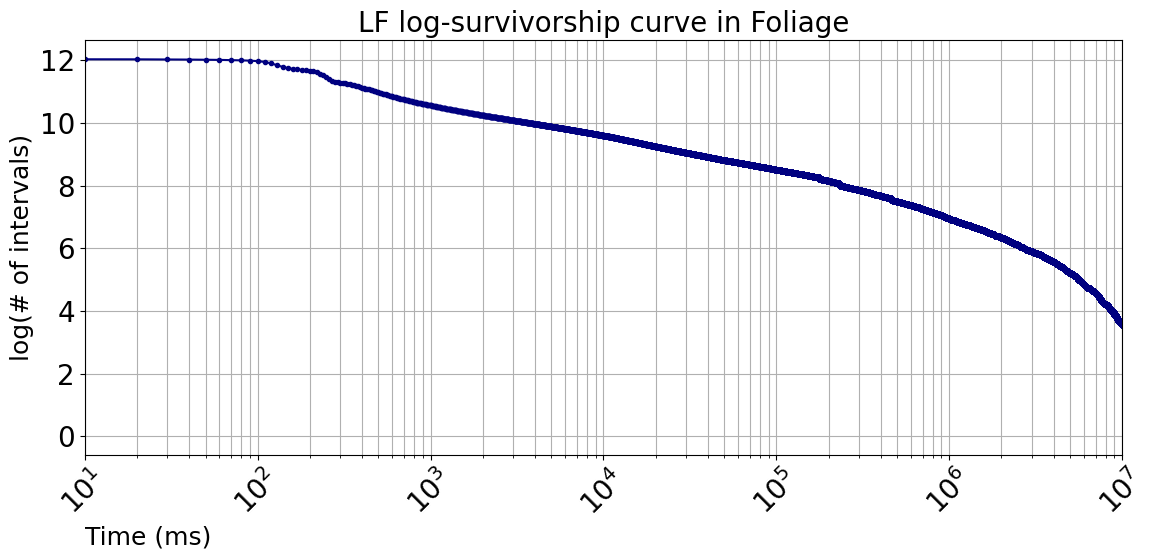

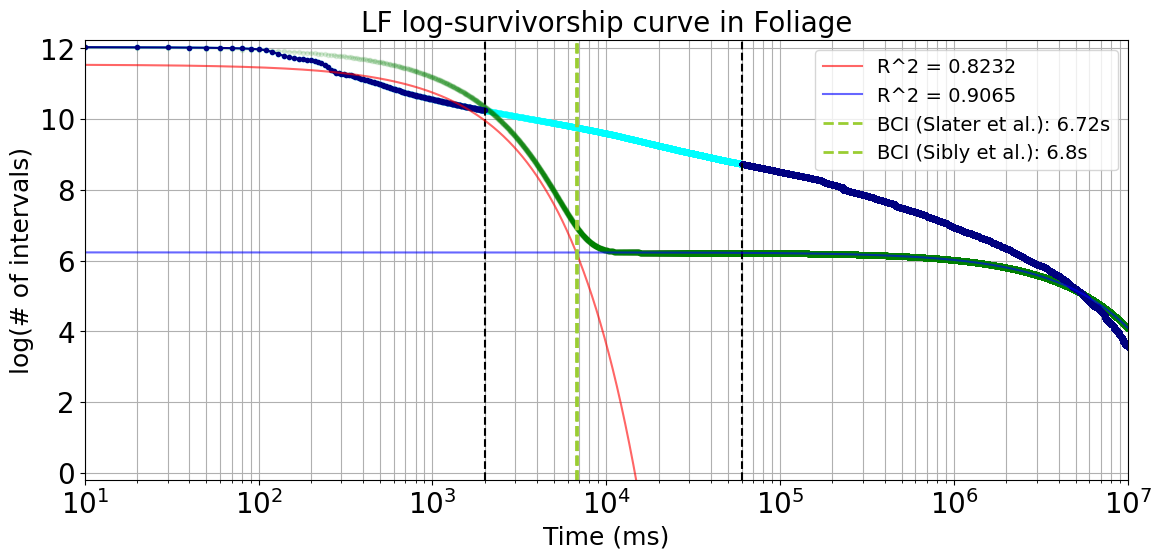

In [39]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [40]:
data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['detector_tag'] = 'bd2'
data_params['assembly_type'] = 'kmeans'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['index_time_block_in_secs'] = 5
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')
bout_params = bt.get_bout_params_from_location(location_df, data_params)
bout_params

{'site_key': 'Foliage', 'LF_bci': 6721.685423068665}

In [41]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
tagged_dets = bt.classify_bouts_in_detector_preds_for_freqgroups(dc_applied_df, bout_params)
bout_metrics = bt.construct_bout_metrics_from_classified_dets(tagged_dets)
bout_metrics

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,2022-06-15 04:42:22.783500000,2022-06-15 04:42:24.721700,742.7835,744.7217,742.7835,744.7217,22890.0,28244.0,LF,2022-06-15 04:30:00,2022-06-15 04:30:00,3,0 days 00:00:01.938200,1.9382
1,2022-06-15 04:43:05.575500000,2022-06-15 04:43:22.591800,785.5755,802.5918,785.5755,802.5918,23750.0,46868.0,LF,2022-06-15 04:30:00,2022-06-15 04:30:00,54,0 days 00:00:17.016300,17.0163
2,2022-06-15 04:44:55.963500000,2022-06-15 04:44:56.323100,895.9635,896.3231,895.9635,896.3231,24609.0,30737.0,LF,2022-06-15 04:30:00,2022-06-15 04:30:00,2,0 days 00:00:00.359600,0.3596
3,2022-06-15 04:45:50.506499999,2022-06-15 04:46:26.216300,950.5065,986.2163,950.5065,986.2163,23750.0,48849.0,LF,2022-06-15 04:30:00,2022-06-15 04:30:00,92,0 days 00:00:35.709800001,35.7098
4,2022-06-15 04:46:54.465500000,2022-06-15 04:46:54.709200,1014.4655,1014.7092,1014.4655,1014.7092,26328.0,34892.0,LF,2022-06-15 04:30:00,2022-06-15 04:30:00,3,0 days 00:00:00.243700,0.2437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,2022-10-17 05:55:12.176500000,2022-10-17 05:55:19.583000,1512.1765,1519.5830,1512.1765,1519.5830,25468.0,34634.0,LF,2022-10-17 05:30:00,2022-10-17 05:30:00,33,0 days 00:00:07.406500,7.4065
10652,2022-10-17 06:10:00.661500000,2022-10-17 06:10:09.401100,600.6615,609.4011,600.6615,609.4011,25468.0,34996.0,LF,2022-10-17 06:00:00,2022-10-17 06:00:00,33,0 days 00:00:08.739600,8.7396
10653,2022-10-17 06:20:43.780500000,2022-10-17 06:20:49.474300,1243.7805,1249.4743,1243.7805,1249.4743,26328.0,34586.0,LF,2022-10-17 06:00:00,2022-10-17 06:00:00,23,0 days 00:00:05.693800,5.6938
10654,2022-10-17 06:42:30.291500000,2022-10-17 06:42:35.001500,750.2915,755.0015,750.2915,755.0015,25468.0,30527.0,LF,2022-10-17 06:30:00,2022-10-17 06:30:00,7,0 days 00:00:04.710000,4.7100


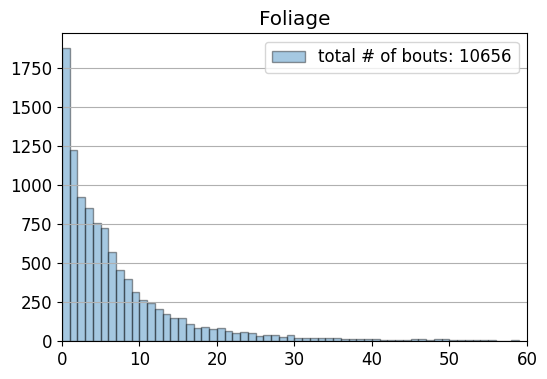

In [42]:
bout_metrics_LF = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
lf_bci = bout_params['LF_bci']

bout_durations_raw_LF = bout_metrics_LF["bout_duration_in_secs"].astype(float)
lf_labels = f'total # of bouts: {len(bout_durations_raw_LF)}'

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size':12})
plt.title(f'{SITE_NAMES[site_key]}')
x_lims = [0, 60]
x_step = 1
plt.hist(bout_durations_raw_LF, bins=np.arange(x_lims[0],x_lims[-1], x_step), edgecolor='k', label=lf_labels, alpha=0.4)
plt.grid(axis='y')
plt.legend(loc=1)
plt.xlim(x_lims[0],x_lims[-1])
plt.show()

In [43]:
bout_durations_raw_LF

0         1.9382
1        17.0163
2         0.3596
3        35.7098
4         0.2437
          ...   
10651     7.4065
10652     8.7396
10653     5.6938
10654     4.7100
10655     4.8850
Name: bout_duration_in_secs, Length: 10656, dtype: float64

Foliage LF Min: 0.0534
Foliage LF Max: 754.4964
Foliage LF Mean: 8.847927967905406
Foliage LF Median: 4.60535


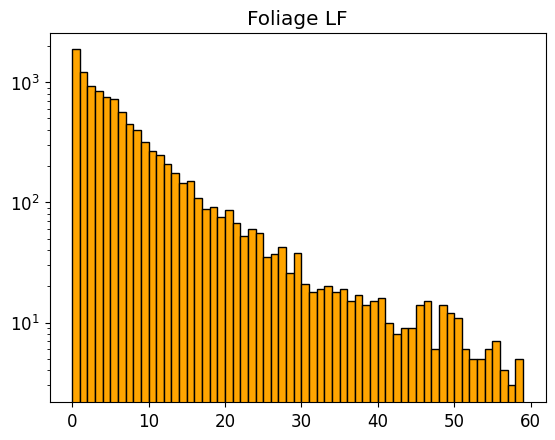

In [44]:
stat_arr = bout_durations_raw_LF
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 60, 1), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

In [45]:
bout_metrics['bout_duration_in_secs'].sort_values()

4755      0.0534
6612      0.0719
9243      0.0768
3719      0.0776
4915      0.0788
          ...   
7665    402.2015
151     410.7645
1710    444.2868
1200    553.4465
1013    754.4964
Name: bout_duration_in_secs, Length: 10656, dtype: float64

In [48]:
bbis_s = get_between_bout_intervals_in_secs(bout_metrics)

Foliage LF Min: 6.722999572753906
Foliage LF Max: 47874.4140625
Foliage LF Mean: 309.6000671386719
Foliage LF Median: 30.462501525878906


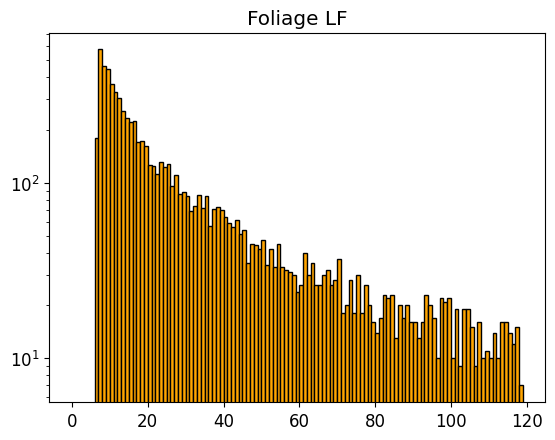

In [49]:
stat_arr = bbis_s
print(f"{site_key} {freq_key} Min: {np.min(stat_arr)}")
print(f"{site_key} {freq_key} Max: {np.max(stat_arr)}")
print(f"{site_key} {freq_key} Mean: {np.mean(stat_arr)}")
print(f"{site_key} {freq_key} Median: {np.median(stat_arr)}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 120, 1), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()